In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
folder_train = '/home/xingguang/Documents/ECE661/hw7/images/training'
folder_test = '/home/xingguang/Documents/ECE661/hw7/images/testing'
classes = ['beach', 'building', 'car', 'mountain', 'tree']
train_data = {'beach':[], 'building':[], 'car':[], 'mountain':[], 'tree':[]}
test_data = {'beach':[], 'building':[], 'car':[], 'mountain':[], 'tree':[]}
for c in list(train_data.keys()):
    for i in range(1, 21):
        img_path = os.path.join(folder_train, c, '{0:02d}.jpg'.format(i))
        train_data[c].append(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))
    for i in range(1, 6):
        img_path = os.path.join(folder_test, c + '_' + str(i) +'.jpg')
        test_data[c].append(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))

In [3]:
def neighborVector(img):
    tl = img[:-2, :-2].copy()
    t = img[:-2, 1:-1].copy()
    tr = img[:-2, 2:].copy()
    l = img[1:-1, :-2].copy()
    c = img[1:-1, 1:-1].copy()
    r = img[1:-1, 2:].copy()
    bl = img[2:, :-2].copy()
    b = img[2:, 1:-1].copy()
    br = img[2:, 2:].copy()
    neighbormap = np.stack([tl, t, tr, l, c, r, bl, b, br], axis=-1)
    nm = neighbormap
    return nm.reshape((-1, nm.shape[-1]))


def lbp_matrix():
    du, dv = np.sqrt(2)/2, np.sqrt(2)/2
    lbp_matrix = np.asarray([[0, 0, 0, 0, 0, 0, 0, 1, 0],
                            [0, 0, 0, 0, (1-du)*(1-dv), du*(1-dv), 0, dv*(1-du), dv*du],
                            [0, 0, 0, 0, 0, 1, 0, 0, 0],
                            [0, du*(1-dv), dv*du, 0, (1-du)*(1-dv), dv*(1-du), 0, 0, 0],
                            [0, 1, 0, 0, 0, 0, 0, 0, 0],
                            [dv*du, du*(1-dv), 0, dv*(1-du), (1-du)*(1-dv), 0, 0, 0, 0],
                            [0, 0, 0, 1, 0, 0, 0, 0, 0],
                            [0, 0, 0, du*(1-dv), (1-du)*(1-dv), 0, dv*du, dv*(1-du), 0]])
    return lbp_matrix.T


def makeminIntVal(intval):
    P = intval.shape[-1]
    idices = [_ for _ in range(P)] * 2
    IntVal = np.zeros((intval.shape[0], P))
    weight = 2 ** np.arange(P-1, -1, -1)
    for i in range(P):
        IntVal[:, i] = np.dot(intval[:, idices[i:i+P]], weight)
    minIntVal = np.min(IntVal, axis=1)
    return minIntVal


def encode(bv):
    N = bv.shape[0]
    P = 8
    hist = np.zeros(P+2)
    for i in range(P+1):
        hist[i] = np.sum(bv == (2**i-1)) / N
    hist[-1] = 1 - np.sum(hist[:-1])
    return hist


def LBP(img):
    neighborVec = neighborVector(img)
    threshold_vec = img[1:-1, 1:-1].reshape((-1,1))
    H = lbp_matrix()
    lbp_map = np.dot(neighborVec, H)
    lbp = lbp_map > threshold_vec
    pattern = lbp.astype(np.int)
    minbv = makeminIntVal(pattern)
    hist = encode(minbv)
    return hist

In [4]:
def KNN(train, test, train_label, test_label, K=5, conf_score=100):
    ntest = np.sum(test_set**2, axis=1).reshape((-1, 1))
    ntrain = np.sum(train_set**2, axis=1).reshape((1, -1))
    tt = np.dot(test_set, train_set.T)
    edistance = np.sqrt(ntest - 2 * tt + ntrain)
    idx = edistance.argsort(axis=1)
    neighbors = train_label[idx[:, 0:5]]
    scores = 1 - np.sort(edistance)
    prediction = []
    confusion_m = np.zeros((5, 5))
    for i in range(ntest.shape[0]):
        p = np.zeros(5)
        for j in range(K):
            p[neighbors[i, j]] += (conf_score + scores[i, j])
        pred = np.argmax(p)
        prediction.append(pred)
        confusion_m[test_label[i], pred] += 1
    acc = np.sum(np.array(prediction)==test_label) / ntest.shape[0]
    return confusion_m, acc

In [5]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [6]:
train_set = np.zeros((100, 10))
train_label = np.zeros(100, dtype=np.int)
test_set = np.zeros((25, 10))
test_label = np.zeros(25, dtype=np.int)
train_idx = 0
test_idx = 0
for i, c in enumerate(classes):
    string = ''
    for j, img in enumerate(train_data[c]):
        train_set[train_idx, :] = LBP(cv2.resize(img, (250,250)))
        if j == 0: 
            for s in train_set[train_idx, :]:
                string += '{:0.4f}, '.format(s)
            print("LBP histogram of the first image in "+c+':', string[:-2])
        train_label[train_idx] = i
        train_idx += 1
    for img in test_data[c]:
        test_set[test_idx, :] = LBP(cv2.resize(img, (250,250)))
        test_label[test_idx] = i
        test_idx += 1        

LBP histogram of the first image in beach: 0.1137, 0.0967, 0.0699, 0.1332, 0.1334, 0.1055, 0.0438, 0.0758, 0.0516, 0.1764
LBP histogram of the first image in building: 0.0798, 0.1075, 0.0597, 0.1886, 0.2005, 0.0908, 0.0352, 0.0870, 0.0333, 0.1176
LBP histogram of the first image in car: 0.0608, 0.2939, 0.0510, 0.1325, 0.1674, 0.0781, 0.0281, 0.0499, 0.0230, 0.1154
LBP histogram of the first image in mountain: 0.1149, 0.1534, 0.0632, 0.1151, 0.1173, 0.0853, 0.0424, 0.0594, 0.0361, 0.2129
LBP histogram of the first image in tree: 0.0666, 0.0813, 0.0867, 0.1340, 0.1786, 0.1132, 0.0641, 0.0864, 0.0649, 0.1243


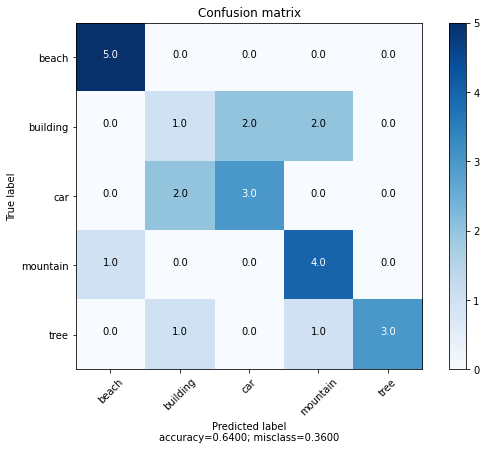

In [7]:
confusion_matrix, accuracy = KNN(train_set, test_set, train_label, test_label, K=5)
plot_confusion_matrix(confusion_matrix,
                          target_names=classes,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)